# <center> RFM - segmentation of Customers </center>




## Getting to know data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
data = pd.read_csv('customer_segmentation_project.csv', encoding = 'ISO-8859-1',
                  dtype = {'CustomerID' : str,
                          'InvoiceID' : str})
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [4]:
# conversion of InvoiceDate column into datetime format

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print('Data period: from {} till {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Data period: from 2010-12-01 till 2011-12-09


In [5]:
print('The lowest Unit Price, excluding negative: {}'.format(data[data['UnitPrice']>0]['UnitPrice'].min()))

The lowest Unit Price, excluding negative: 0.001


In [6]:
print('Number of unique customers', data['CustomerID'].nunique(), '\n')
print('Number of unique countries',data[data['Country'] != 'Unspecified']['Country'].value_counts().count(), '\n')

Number of unique customers 4372 

Number of unique countries 37 



## Preprocessing and Data cleaning

In [7]:
print('Number of missing values: {}'.format(data.isnull().sum().sum()), '\n')
data.dropna(subset = ['CustomerID'], inplace = True)
print('Number of left entries', data.shape[0])

Number of missing values: 136534 

Number of left entries 406829


In [8]:
print('Number of duplicates: {}'.format(data.duplicated().sum()), '\n')
data.drop_duplicates(inplace = True)
print('Number of entries left', data.shape[0])

Number of duplicates: 5225 

Number of entries left 401604


There are negative values in the column Quantity. It is worth to review the nature of these entries

In [9]:
negative_quantity = data[(data['Quantity'] < 0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  
141 2010-12-01 09:41:00      27.50      14527  United Kingdom  
154 2010-12-01 09:49:00       4.65      15311  United Kingdom  
235 2010-12-01 10:24:00       1.65      17548  United Kingdom  
236 2010-12-01 10:24:00       0.29      17548  United Kingdom  
237 2010-12-01 10:24:00       0.29      17548  United Kingdom

Are all records from the table with a negative quantity of goods indeed return transactions. If a transaction is not a return, but contains a negative quantity of goods, this will be a reason to consider in an outlier

In [10]:
print('All returns', negative_quantity.shape[0] == negative_quantity['InvoiceNo'].str.contains('C').count())

All returns True


Currently, each unique product has a seperate row in the table - this makes it difficult to determine the total number of return. First, it is necessary to determine how many unique products are specified in the transaction for each unique "customer - order" pair.

In [11]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24

It is necessary to creat the auxiliary table with the feature order canceled. If the feature - 1, then the product was returned and 0 - canceled.

In [12]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)

print('% of orders in the table are refund:', round(nb_products_per_basket['order_canceled'].value_counts()[1] / nb_products_per_basket.shape[0]*100))

% of orders in the table are refund: 16


In [13]:
# Explore the canceled orders

nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

CustomerID InvoiceNo  Number of products  order_canceled
1       12346   C541433                   1               1
23      12352   C545329                   2               1
24      12352   C545330                   1               1
25      12352   C547388                   7               1
39      12359   C549955                   2               1

In [14]:
# Review all transactions belonging to ID 12346, as an example

data[data['CustomerID'] == '12346']

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

              InvoiceDate  UnitPrice CustomerID         Country  
61619 2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624 2011-01-18 10:17:00       1.04      12346  United Kingdom

**Hypothesis**: for each cancelled transaction in the data set, there is an analogue with the same product code, customer ID and the opposite value of the product quantity:

- **Yes, True**
  
- **No, False**

In [15]:
for index, col in negative_quantity.iterrows():
    if data[(data['CustomerID'] == col['CustomerID']) & (data['Quantity'] == -col['Quantity']) &\
    (data['StockCode'] == col['StockCode'])].shape[0] == 0:
        print(col)
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                   14527
Country             United Kingdom
Name: 141, dtype: object


In [16]:
# Review all transactions belonging to ID 14527

data[data['CustomerID'] == '14527'].head(5)

InvoiceNo StockCode                        Description  Quantity  \
141    C536379         D                           Discount        -1   
8963    537159     22112         CHOCOLATE HOT WATER BOTTLE         6   
8964    537159     22111       SCOTTIE DOG HOT WATER BOTTLE         1   
8965    537159     21479      WHITE SKULL HOT WATER BOTTLE          1   
8966    537159     22114  HOT WATER BOTTLE TEA AND SYMPATHY         6   

             InvoiceDate  UnitPrice CustomerID         Country  
141  2010-12-01 09:41:00      27.50      14527  United Kingdom  
8963 2010-12-05 13:17:00       4.95      14527  United Kingdom  
8964 2010-12-05 13:17:00       4.95      14527  United Kingdom  
8965 2010-12-05 13:17:00       3.75      14527  United Kingdom  
8966 2010-12-05 13:17:00       3.95      14527  United Kingdom

Here is the first line, which contains order C536379 with a cancellation flag - there is no opposite analog in terms of the number of goods. The reason lies in the type of goods: this product is designated as a discounted product "StockCode", and there are no analogs with a positive number of goods in the order for such transactions.

**Hypothesis**: for each cancelled transaction in the data set there is its counterpart with the same product code, customer ID and the opposite value of the product quantity if the product is not subject to discounts.

- **Yes, the hypothesis is correct**
  
- **No, the hypothesis is not correct**

In [17]:
negative_quantity_no_D = negative_quantity[negative_quantity['StockCode'] != 'D']

for index, col in negative_quantity_no_D.iterrows():
    if data[(data['CustomerID'] == col['CustomerID']) & (data['Quantity'] == -col['Quantity']) & \
    (data['Description'] == col['Description'])].shape[0] == 0:
        print(col, '\n')
    else: break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
Name: 154, dtype: object 

InvoiceNo                             C536391
StockCode                               22556
Description    PLASTERS IN TIN CIRCUS PARADE 
Quantity                                  -12
InvoiceDate               2010-12-01 10:24:00
UnitPrice                                1.65
CustomerID                              17548
Country                        United Kingdom
Name: 235, dtype: object 

InvoiceNo                               C536391
StockCode                                 21984
Description    PACK OF 12 PINK PAISLEY TISSUES 
Quantity                                    -24
InvoiceDat

In [18]:
# Review all transactions belonging to ID 15311 & Stock Code 35004C

data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

InvoiceNo StockCode                      Description  Quantity  \
154     C536383    35004C  SET OF 3 COLOURED  FLYING DUCKS        -1   
9200     537195    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
18196   C537805    35004C  SET OF 3 COLOURED  FLYING DUCKS        -1   
28630    538651    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
39381   C539640    35004C  SET OF 3 COLOURED  FLYING DUCKS        -3   
44157    540157    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
59542    541293    35004C  SET OF 3 COLOURED  FLYING DUCKS        12   
78333   C542866    35004C  SET OF 3 COLOURED  FLYING DUCKS        -2   

              InvoiceDate  UnitPrice CustomerID         Country  
154   2010-12-01 09:49:00       4.65      15311  United Kingdom  
9200  2010-12-05 13:55:00       4.65      15311  United Kingdom  
18196 2010-12-08 13:18:00       4.65      15311  United Kingdom  
28630 2010-12-13 15:07:00       4.65      15311  United Kingdom  
39381 2010-12-20 15:27:00       4.65      15311  United Kingdom  
44157 2011-01-05 11:41:00       4.65      15311  United Kingdom  
59542 2011-01-17 13:39:00       4.65      15311  United Kingdom  
78333 2011-02-01 12:14:00       4.65      15311  United Kingdom

- There is a canceled order in the first line (the Invoice number starts with C). However, there is the question: for which order was this cancellation received, since there are no earlier transaction records related to this customer. The answer is that the customer's purchase order for this product was received before December 2010 and this information is not in the data set.
  
- The next two lines shoe that the customer can cancel not the entire order, but only a part of it (on 05.12, the customer purchased 12 units of goods, and on 08.12 - issues a return for only one unit of goods).

The peculiarities of order cancellations are clear. Therefore, it is worth to create the feature "QuantityCanceled" in the data set, which will indicate the quantity of goods subsequently returned for each transaction.

In [19]:
data_sales = data[(data['Quantity'] > 0)].reset_index()
data_returns = data[(data['Quantity'] < 0)].reset_index().drop(['Description', 'Country', 'InvoiceNo',
                                                               'UnitPrice'], axis = 1)
data_merged = data_sales.merge(data_returns, how = 'inner', on = ['StockCode', 'CustomerID'])
data_merged = data_merged[(data_merged['InvoiceDate_x'] < data_merged['InvoiceDate_y'])]

duplicate_list = list(set(data_merged[data_merged.duplicated(['index_y'])]['index_y']))

data_merged['dup'] = 0
data_merged.loc[data_merged['index_y'].isin(duplicate_list), 'dup'] = 1
data_merged = data_merged[(data_merged['Quantity_x'] >= (-data_merged['Quantity_y'])) | (data_merged['dup'] == 0)]

data_group = data_merged.groupby(['index_y']).agg({'index_x': ['max'] }).reset_index()
data_group.columns = ['index_y', 'index_x']

data_group_2 = data_group.groupby(['index_x',]).agg( {'index_y': ['max'] }).reset_index()
data_group_2.columns = ['index_x', 'index_y']

data_returns_merged = data_returns.merge(data_group_2, how = 'inner',left_on = 'index',right_on = 'index_y')
data_returns_merged.drop (data_returns_merged.columns [[0,1,3,4]], axis = 1 , inplace = True )

data_merged_2 = data_sales.merge(data_returns_merged, how = 'left', left_on = 'index', right_on = 'index_x')
data_merged_2['Quantity_y'] = (-data_merged_2['Quantity_y']). fillna (0)

data_merged_2.drop (data_merged_2.columns [[0,10,11]], axis= 1 , inplace= True )
data_merged_2.rename(columns = {'Quantity_x':'Quantity', 'Quantity_y':'QuantityCanceled'}, inplace = True )

print('Total number of cancelled goods', data_merged_2['QuantityCanceled'].sum())

Total number of cancelled goods 245266.0


In [20]:
# Dropping the transactions with returns (negative number in Quantity)

data_merged_2 = data_merged_2.loc[data_merged_2['Quantity'] >= 0]
print('Number of entries left', data_merged_2.shape[0])

Number of entries left 392732


The next issue is the special types of transaction, marked with letters in the column StockCode

In [21]:
data = data_merged_2.copy()

import re

list_ind = []

for x in data['StockCode']:
    if (re.match(r'^[a-zA-Z]+', x)):
        list_ind.append(x[0])

print('Number of entries with letters:', len(list_ind), '\n')
print('Unique letter / symbols:', set(list_ind))

Number of entries with letters: 1549 

Unique letter / symbols: {'D', 'C', 'M', 'B', 'P'}


In [22]:
# Dropping the entries with letters

data = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex = True) == False]
print('Number of entries left:', data.shape[0])

Number of entries left: 391183


In [23]:
print('Number of transactions with Price equals zero: {}'.format(data[data['UnitPrice'] == 0]['UnitPrice'].count()))

# Dropping entries with zero prices
data.drop(data[data['UnitPrice'] == 0].index, axis = 0, inplace = True)

print('Number of entries left:', data.shape[0])      

Number of transactions with Price equals zero: 33
Number of entries left: 391150


In [24]:
# The data set cleaning process is done; Save the data set

df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391150 entries, 0 to 392731
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  object        
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  object        
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 29.8+ MB


## EDA

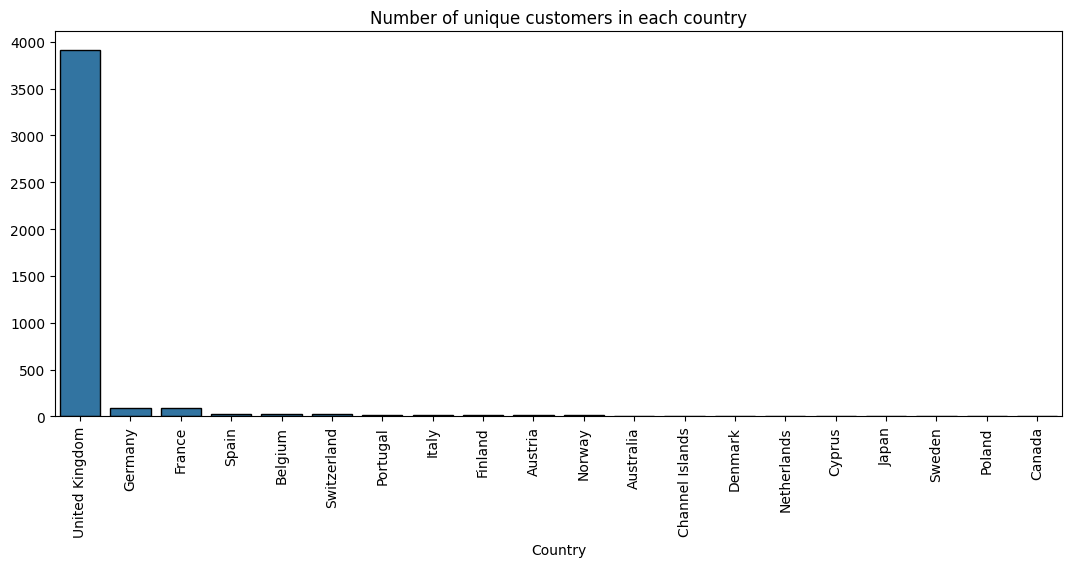

In [25]:
country = df.groupby('Country')['CustomerID'].nunique().nlargest(20)
country = country.sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = country.index, y = country.values, ax = ax)
ax.set_title('Number of unique customers in each country')
ax.xaxis.set_tick_params(rotation = 90);

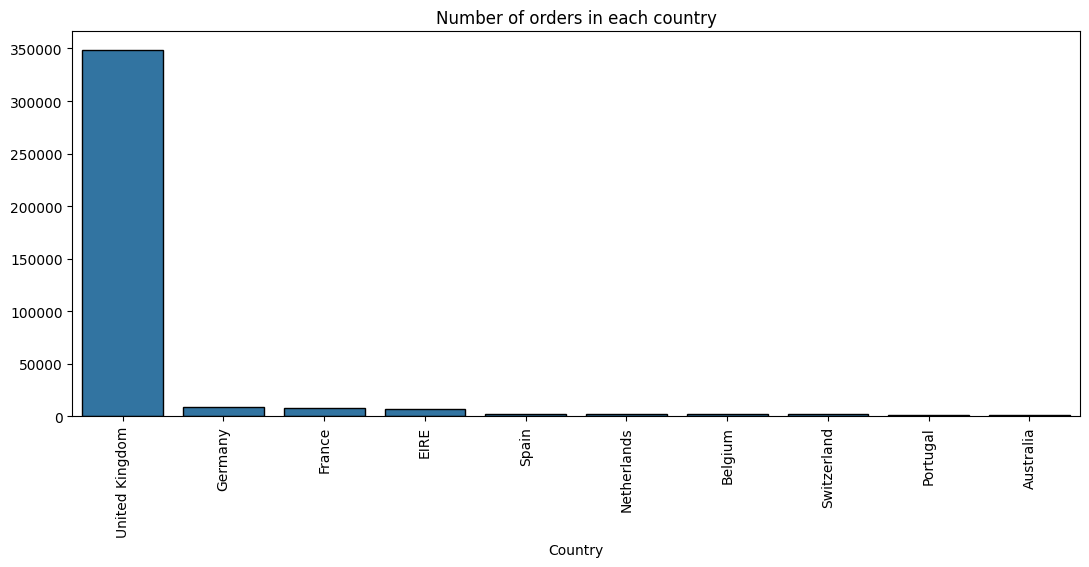

In [26]:
order = df.groupby('Country')['InvoiceNo'].count().nlargest(10)

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = order.index, y = order.values, ax = ax)
ax.set_title('Number of orders in each country')
ax.xaxis.set_tick_params(rotation = 90);

In [27]:
# Adding new feature Total Price

df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCanceled'])
print('Average Total Price:', round(df['TotalPrice'].mean()))

Average Total Price: 21


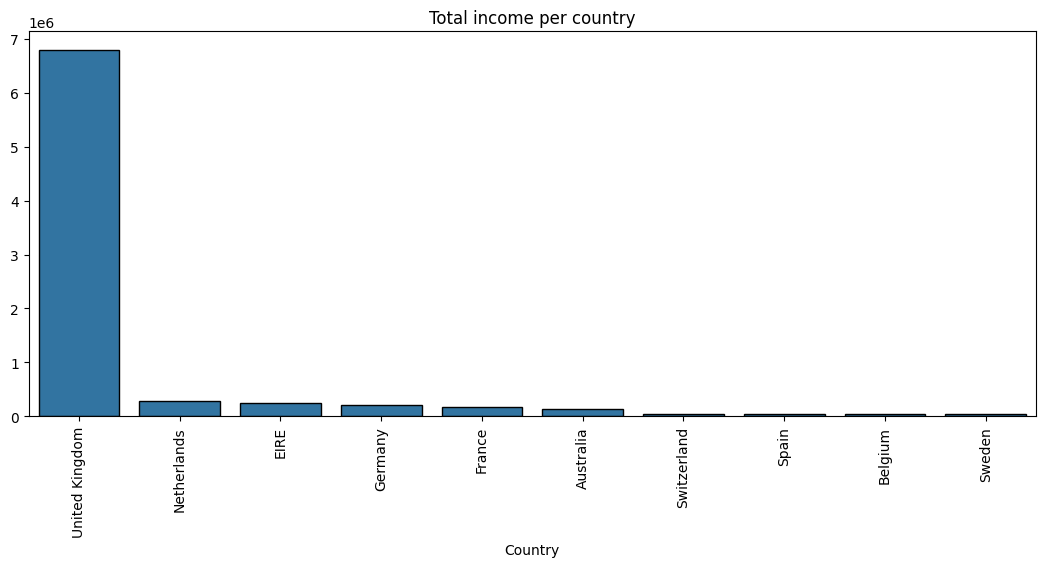

In [28]:
income = df.groupby('Country')['TotalPrice'].sum().nlargest(10)

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = income.index, y = income.values, ax = ax)
ax.set_title('Total income per country')
ax.xaxis.set_tick_params(rotation = 90);

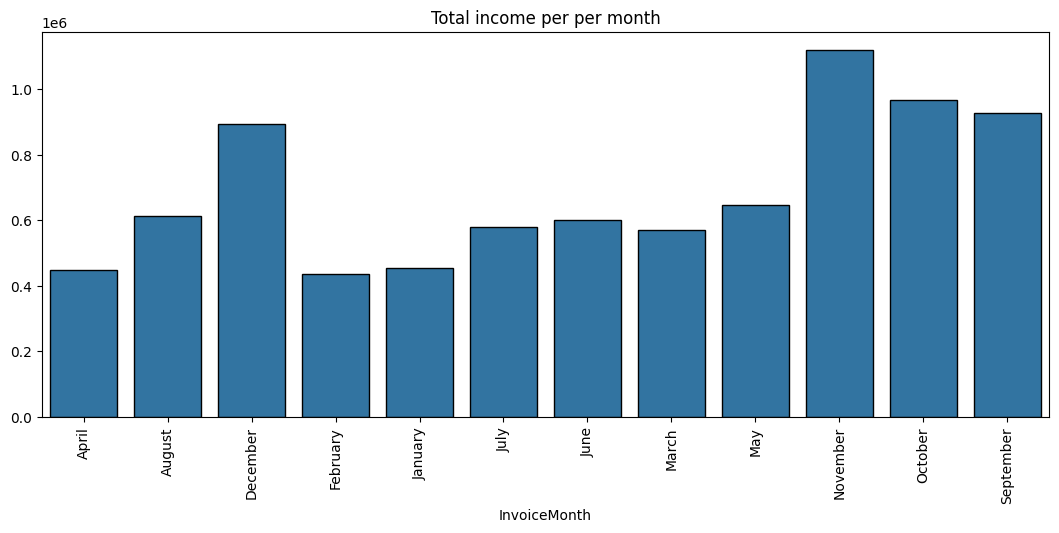

In [29]:
# Adding new features & visualization

df['InvoiceMonth'] = pd.to_datetime(df['InvoiceDate']).dt.month_name()
df['InvoiceWeekDay'] = pd.to_datetime(df['InvoiceDate']).dt.day_name()
df['InvoiceHour'] = pd.to_datetime(df['InvoiceDate']).dt.hour

income_month = df.groupby('InvoiceMonth')['TotalPrice'].sum()

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = income_month.index, y = income_month.values, ax = ax)
ax.set_title('Total income per per month')
ax.xaxis.set_tick_params(rotation = 90);

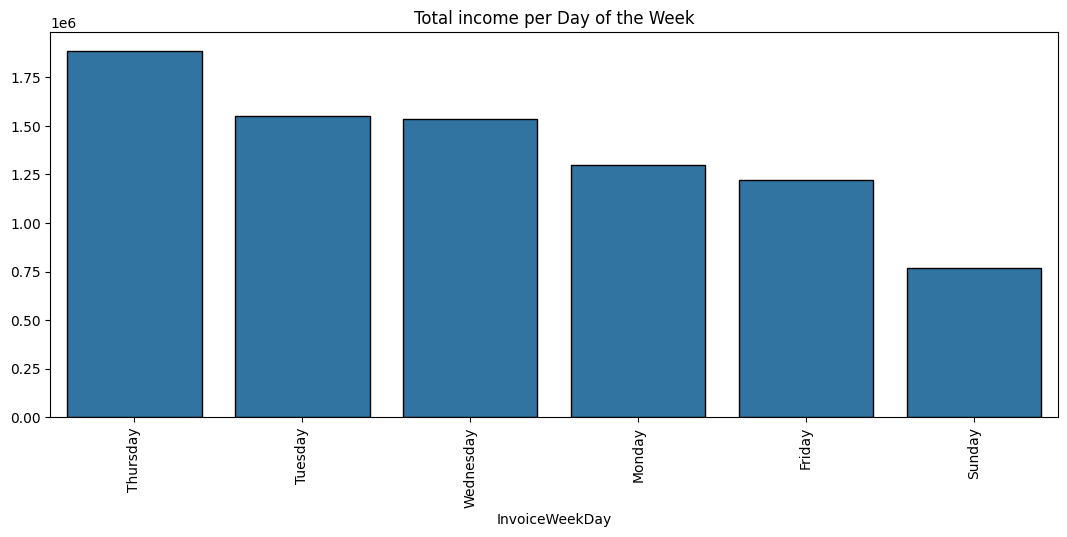

In [30]:
income_weekday = df.groupby('InvoiceWeekDay')['TotalPrice'].sum().sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = income_weekday.index, y = income_weekday.values, ax = ax)
ax.set_title('Total income per Day of the Week')
ax.xaxis.set_tick_params(rotation = 90);

InvoiceHour     6    7     8     9     10    11     12     13    14    15  \
InvoiceWeekDay                                                              
Friday           0  128  1816  4336  7106  7155   9722   8267  7194  4655   
Monday           0   60  1557  4320  6067  7370  10553  10417  9083  7601   
Sunday           0    0     0    25  3470  9912  13076  11371  9569  9863   
Thursday         1   64  1751  4535  7483  7105  12863  11406  9140  7582   
Tuesday          0   64  1700  4517  6538  8403  11854  10243  9393  7189   
Wednesday        0   59  1800  4054  6894  8264  12648  11096  8673  7725   

InvoiceHour       16    17    18    19   20  
InvoiceWeekDay                               
Friday          2081  1382     2    88    7  
Monday          3983  2952     0     0    0  
Sunday          3798     0     0     0    0  
Thursday        6006  4274  2815  3127  752  
Tuesday         3578  1945    67     0    0  
Wednesday       4180  2344     0    14   18

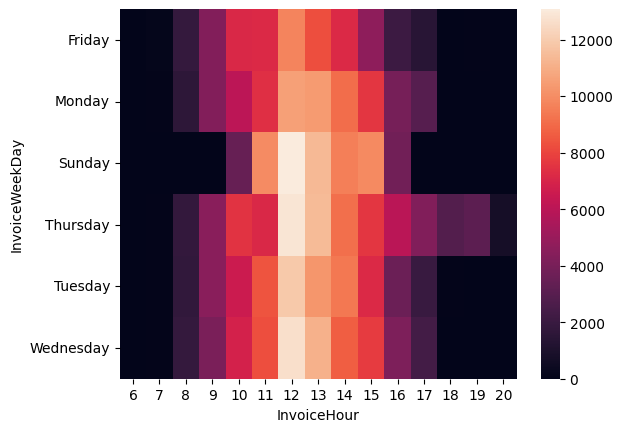

In [31]:
pivot = df.pivot_table(values = 'Quantity',
                      index = 'InvoiceWeekDay',
                      columns = 'InvoiceHour',
                      aggfunc = 'count',
                      fill_value = 0)
display(pivot)

sns.heatmap(pivot);

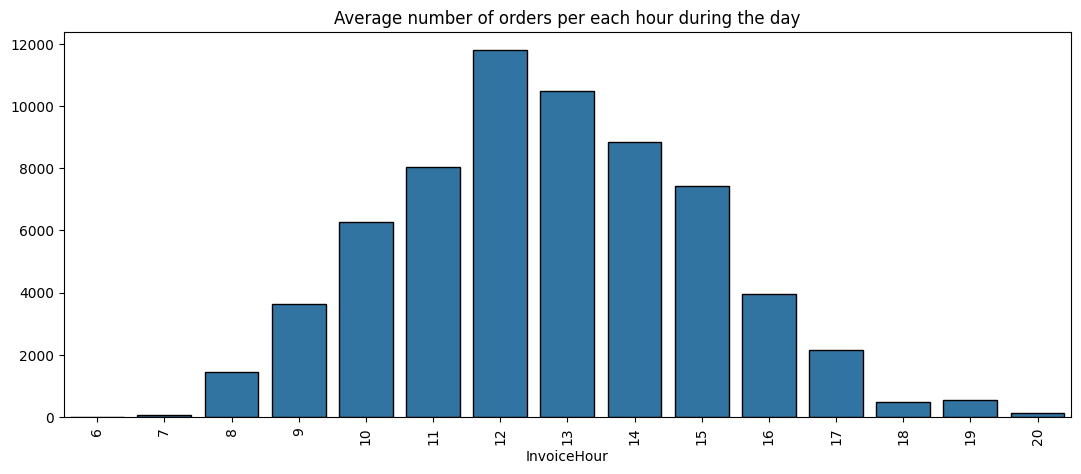

In [32]:
by_hour = pivot.mean()

fig, ax = plt.subplots(figsize = (13, 5))
sns.barplot(x = by_hour.index, y = by_hour.values, ax = ax)
ax.set_title('Average number of orders per each hour during the day')
ax.xaxis.set_tick_params(rotation = 90);

## RFM - customer segmentation

RFM table is the data grouped by customer ID with calculated following aggregated characteristics:

- **Recency** for a customer is calculated as the difference between the date & time of the last order and the reference point, converted into days;
  
- **Frequency** is calculated as the total number of unique orders made by a customer;

- **Monetary Value** is calculated as the total amount of money that a customer spent on the products (including returns)

In [33]:
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = pd.to_datetime('2011-12-10') - recency['InvoiceDate']
recency['Recency'] = recency['Recency'].dt.days

rfm_initial = pd.DataFrame({'Recency' : recency['Recency'].values,
                   'Frequency' : df.groupby('CustomerID')['InvoiceNo'].nunique(),
                   'Monetary' : df.groupby('CustomerID')['TotalPrice'].sum()})

rfm_initial.head()

Recency  Frequency  Monetary
CustomerID                              
12346           325          1      0.00
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1457.55
12350           310          1    294.40

In [34]:
print('Customers made orders over 200 days ago: {}'.format(rfm_initial[rfm_initial['Recency'] > 200].shape[0]))
print('Average orders number per year: {}'.format(round(rfm_initial['Frequency'].mean())))
print('Total purchases of customer ID "12360": {}'.format(round(rfm_initial.loc['12360'][2])))

Customers made orders over 200 days ago: 743
Average orders number per year: 4
Total purchases of customer ID "12360": 2302


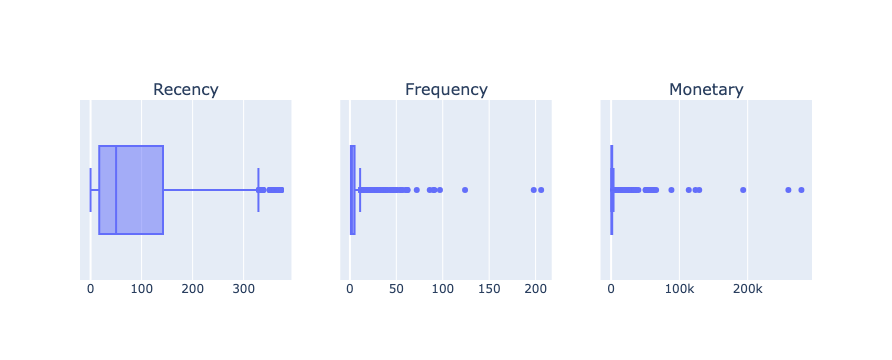

In [35]:
# Visualization

boxes = [px.box(rfm_initial, x = column) for column in rfm_initial.columns]

fig = make_subplots(rows = 1, cols = 3, subplot_titles = ('Recency', 'Frequency', 'Monetary'))

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row = 1, col = i+1)

fig.update_layout(showlegend = True)
fig.show()

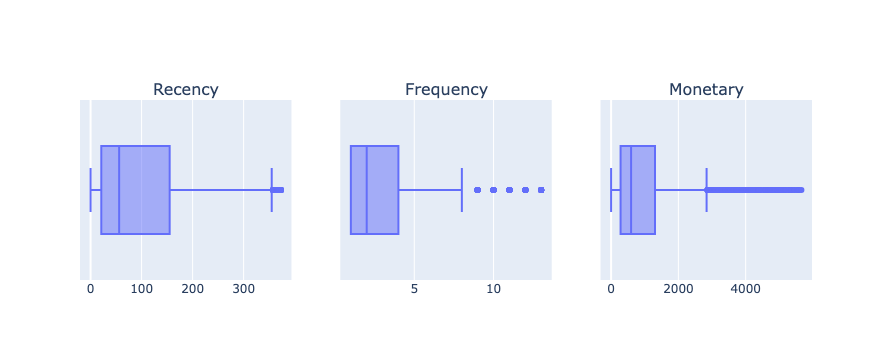

In [36]:
# Remove outliers & visualization

rfm = rfm_initial[(rfm_initial.Frequency <= rfm_initial.Frequency.quantile(0.95)) &\
(rfm_initial.Monetary <= rfm_initial.Monetary.quantile(0.95))]

boxes = [px.box(rfm, x = column) for column in rfm.columns]

fig = make_subplots(rows = 1, cols = 3, subplot_titles = ('Recency', 'Frequency', 'Monetary'))

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row = 1, col = i+1)

fig.update_layout(showlegend = True)
fig.show()

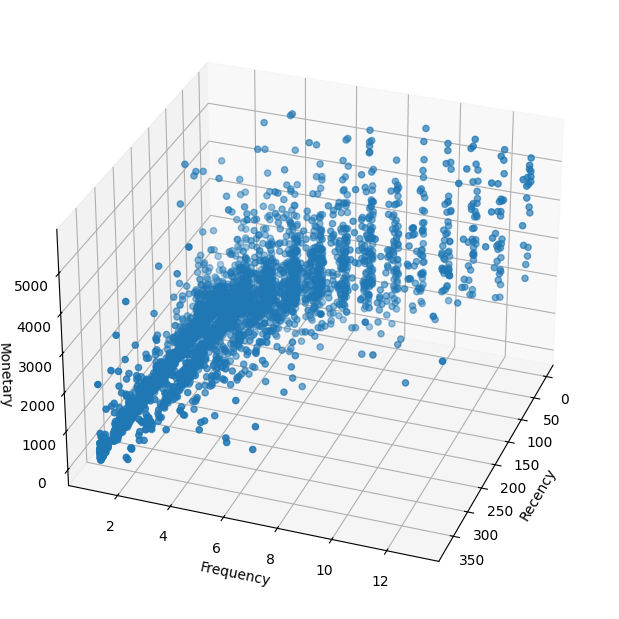

In [37]:
# Visualization of three-dimensional feature space

fig = plt.figure(figsize = (6, 6))
ax = Axes3D(fig)

fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

ax.scatter(rfm['Recency'].to_list(),
          rfm['Frequency'].to_list(),
          rfm['Monetary'].to_list())

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

The graph shows that there are customers with high values of Monetary and Frequency parameters - these are probably the best customers, who buy most often and bring in the most money. However, it is difficult to say from the total mass of points how many clusters are. It is worth to try to use various algorithms for dimensionality reduction.

### PCA method

In [38]:
pipeline_pca = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('PCA', decomposition.PCA(n_components = 2))])

rfm_pca = pipeline_pca.fit_transform(rfm)

pca_component_first = pipeline_pca['PCA'].explained_variance_ratio_[0]

print('The first component explains the proportion of variance: {}'.format(round(pca_component_first, 2)))

The first component explains the proportion of variance: 0.68


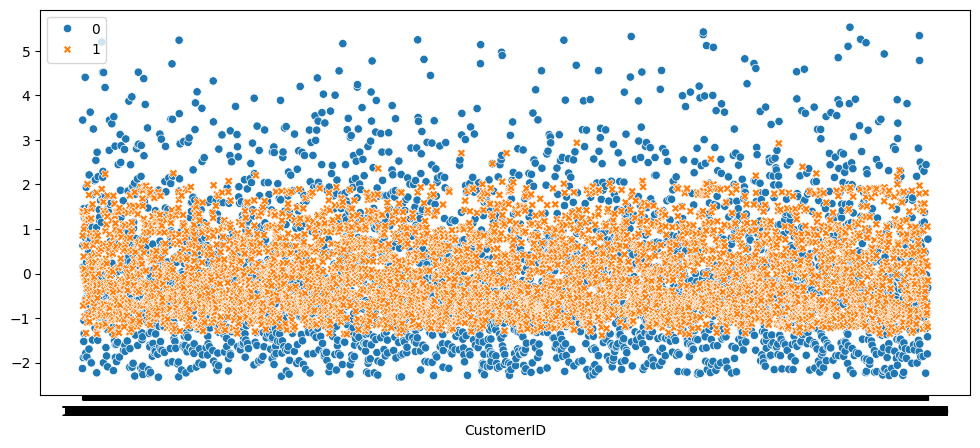

In [39]:
# visualization

rfm_pca = pd.DataFrame(rfm_pca, index = rfm.index)
fig = plt.figure(figsize = (12, 5))
sns.scatterplot(data = rfm_pca);

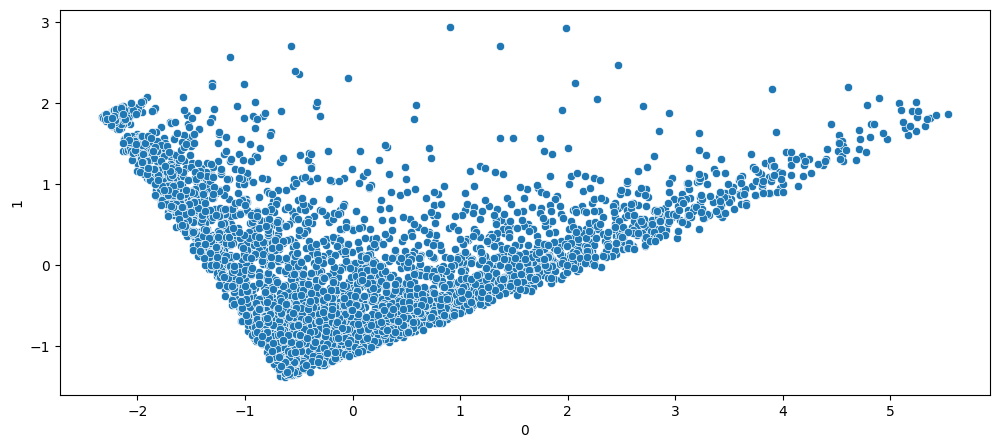

In [40]:
fig = plt.figure(figsize = (12, 5))

sns.scatterplot(data = rfm_pca,
               x = rfm_pca.loc[:,0],
               y = rfm_pca.loc[:,1]);

It makes sense to divide this space of principal components into segments by using the k-means method and calculate the silhouette score.

Max silhouette: 0.52


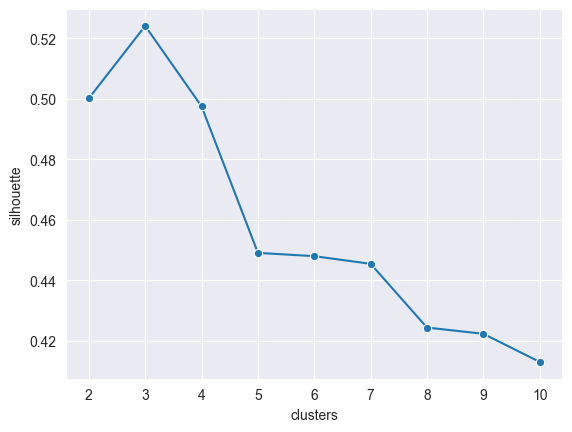

In [41]:
def get_silhouette_kmeans(cluster_num, data):
    k_means = cluster.KMeans(n_clusters = cluster_num, n_init = 'auto', random_state = 42)
    k_means.fit(data)
    silhouette = metrics.silhouette_score(data, k_means.predict(data))
    return silhouette

results_kmeans = {'silhouette' : [], 'clusters' : []}

for cluster_num in range(2, 11):
    results_kmeans['silhouette'].append(get_silhouette_kmeans(cluster_num, rfm_pca))
    results_kmeans['clusters'].append(cluster_num)

plot_df_kmeans = pd.DataFrame(results_kmeans)

sns.set_style('darkgrid')
sns.lineplot(x = plot_df_kmeans['clusters'], y = plot_df_kmeans['silhouette'], marker = 'o');

print('Max silhouette: {}'.format(round(max(results_kmeans['silhouette']), 2)))

It is valuable to use Gaussian Mixture Model and calculate the silhouette score.

Max silhouette: 0.44


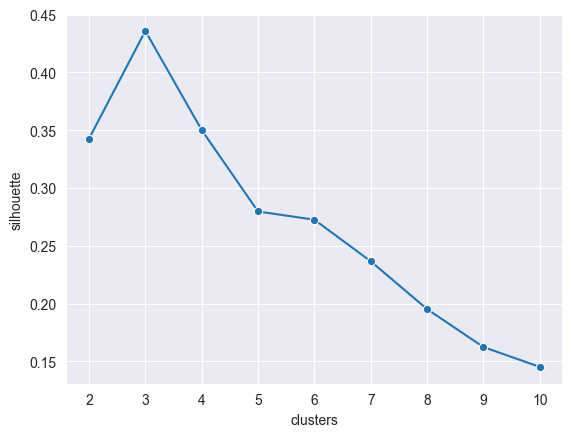

In [42]:
def get_silhouette_gaussian(cluster_num, data):
    gaussian = mixture.GaussianMixture(n_components = cluster_num, random_state = 42)
    gaussian.fit(data)
    silhouette = metrics.silhouette_score(data, gaussian.predict(data))
    return silhouette

results_gaussian = {'silhouette' : [], 'clusters' : []}

for cluster_num in range(2, 11):
    results_gaussian['silhouette'].append(get_silhouette_gaussian(cluster_num, rfm_pca))
    results_gaussian['clusters'].append(cluster_num)

plot_df_gaussian = pd.DataFrame(results_gaussian)

sns.set_style('darkgrid')
sns.lineplot(x = plot_df_gaussian['clusters'], y = plot_df_gaussian['silhouette'], marker = 'o');

print('Max silhouette: {}'.format(round(max(results_gaussian['silhouette']), 2)))

The silhouette score is higher with k-means method, therefore this model will be used to predict the segments.

In [43]:
kmeans = cluster.KMeans(n_clusters = 3, n_init = 'auto', random_state = 42)
kmeans.fit(rfm_pca)

rfm_pca.loc[:, 'Label'] = kmeans.labels_
rfm_pca.head()

0         1  Label
CustomerID                           
12346      -2.135201  1.401596      1
12347       3.447125  0.852872      0
12348       0.629103  0.083217      2
12349       0.152932 -0.720954      2
12350      -1.888765  1.382645      1

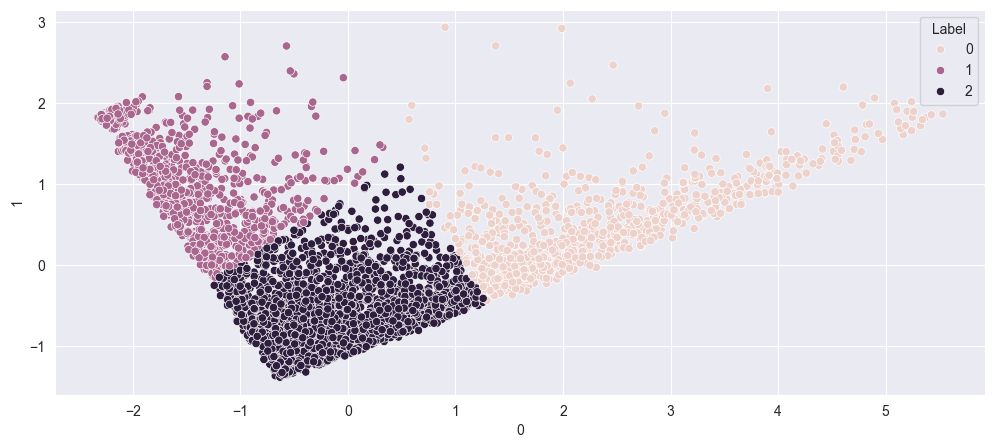

In [44]:
# Visualization

fig = plt.figure(figsize = (12, 5))

sns.scatterplot(data = rfm_pca,
               x = rfm_pca.loc[:,0],
               y = rfm_pca.loc[:,1],
               hue = 'Label');

The results: there are three customer segments. It is reasonable to create a profile for these segments. To create a cluster profile, it is necessary to group the RFM table by the resulting clusters and calculate the average for each feature.

In [45]:
rfm['Label'] = rfm_pca['Label'].values

rfm_group = rfm.groupby('Label').mean()

display(rfm_group)
print('Max average value of Frequency: {}'.format(round(rfm_group['Frequency'].max())))

Recency  Frequency     Monetary
Label                                    
0       32.010349   7.076326  2662.157012
1      253.283716   1.405594   386.598472
2       51.079295   2.332599   661.306912

Max average value of Frequency: 7


It is good idea to look at the clusters profiles using the scatter polar diagram from Plotly library

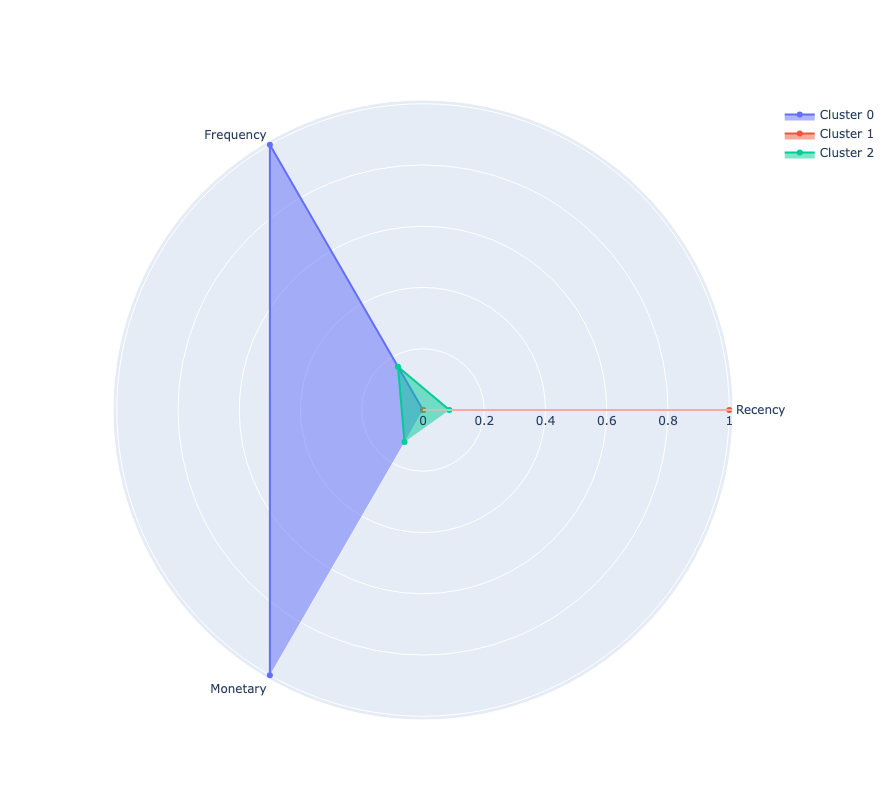

In [46]:
def plot_cluster_profile(grouped_data, n_clusters):
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns = grouped_data.columns)
    features = grouped_data.columns

    fig = go.Figure()
    for i in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r = grouped_data.iloc[i].values,
            theta = features,
            fill = 'toself',
            name = f'Cluster {i}',
        ))

    fig.update_layout(
        showlegend = True,
        autosize = False,
        width = 800,
        height = 800,
    )
    fig.show()

plot_cluster_profile(rfm_group, 3)

### t-SNE algorithmn

In [47]:
rfm.drop('Label', axis = 1, inplace = True)

pipeline_tsne = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                                  ('tsne', manifold.TSNE(n_components = 2,
                                                        perplexity = 50,
                                                        random_state = 100))])

rfm_tsne = pipeline_tsne.fit_transform(rfm)
rfm_tsne = pd.DataFrame(rfm_tsne)

print('Value of the Kullback-Leibler divergence: {}'.format(round(pipeline_tsne['tsne'].kl_divergence_, 2)))

Value of the Kullback-Leibler divergence: 0.54


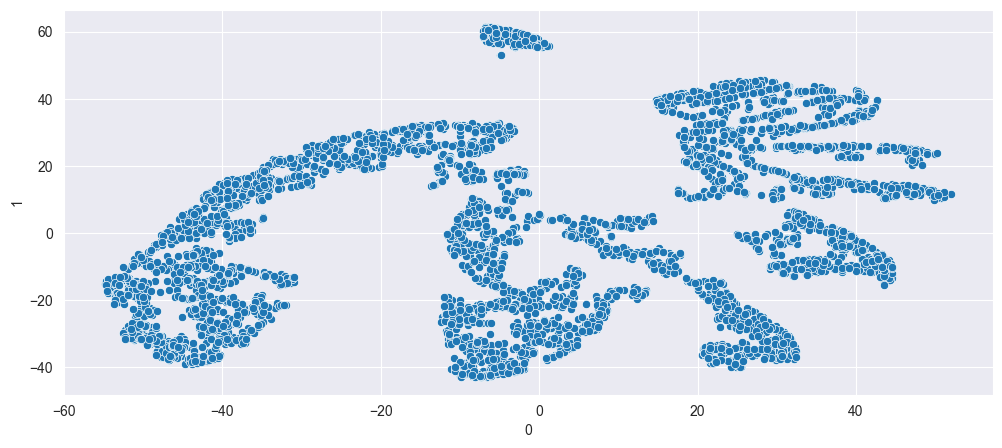

In [48]:
# Visualization

fig = plt.figure(figsize = (12, 5))

sns.scatterplot(data = rfm_tsne,
               x = rfm_tsne.loc[:,0],
               y = rfm_tsne.loc[:,1]);

Max silhouette: 0.4816


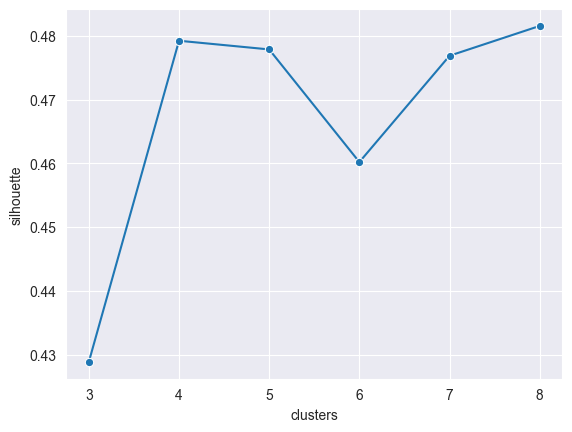

In [49]:
# k-means method

results_kmeans_tsne = {'silhouette' : [], 'clusters' : []}

for cluster_num in range(3, 9):
    results_kmeans_tsne['silhouette'].append(get_silhouette_kmeans(cluster_num, rfm_tsne))
    results_kmeans_tsne['clusters'].append(cluster_num)

plot_df_tsne = pd.DataFrame(results_kmeans_tsne)

sns.set_style('darkgrid')
sns.lineplot(x = plot_df_tsne['clusters'], y = plot_df_tsne['silhouette'], marker = 'o');

print('Max silhouette:', round(max(results_kmeans_tsne['silhouette']), 4))

Max silhouette: 0.4688


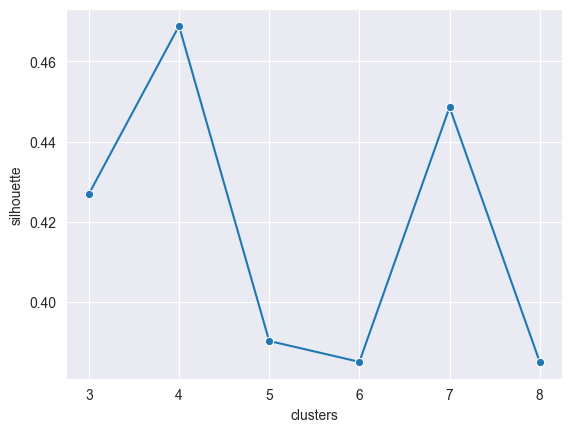

In [50]:
# Gaussian Mixture Model

results_gaussian_tsne = {'silhouette' : [], 'clusters' : []}

for cluster_num in range(3, 9):
    results_gaussian_tsne['silhouette'].append(get_silhouette_gaussian(cluster_num, rfm_tsne))
    results_gaussian_tsne['clusters'].append(cluster_num)

plot_df_tsne_gaussian = pd.DataFrame(results_gaussian_tsne)

sns.set_style('darkgrid')
sns.lineplot(x = plot_df_tsne_gaussian['clusters'],
            y = plot_df_tsne_gaussian['silhouette'], marker = 'o');

print('Max silhouette:', round(max(results_gaussian_tsne['silhouette']),4))

Max silhouette: 0.479


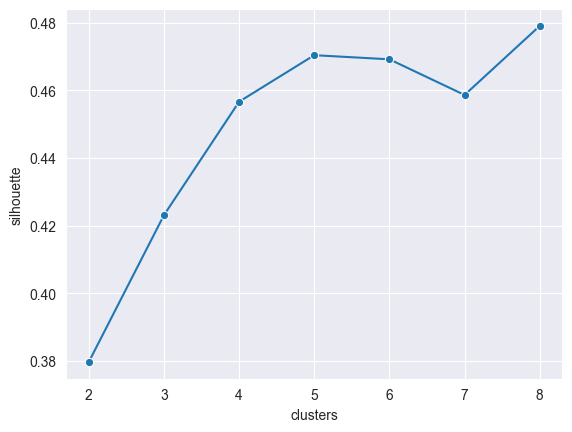

In [51]:
# Agglomerative Clustering algorithm

def get_silhouette_agg(cluster_num, data):
    agg_cl = cluster.AgglomerativeClustering(n_clusters = cluster_num)
    agg_cl.fit(data)
    silhouette = metrics.silhouette_score(data, agg_cl.labels_)
    return silhouette

results_agg_cl = {'silhouette' : [], 'clusters' : []}

for cluster_num in range(2, 9):
    results_agg_cl['silhouette'].append(get_silhouette_agg(cluster_num, rfm_tsne))
    results_agg_cl['clusters'].append(cluster_num)

plot_df_agg_cl = pd.DataFrame(results_agg_cl)

sns.set_style('darkgrid')
sns.lineplot(x = plot_df_agg_cl['clusters'], y = plot_df_agg_cl['silhouette'], marker = 'o');

print('Max silhouette:', round(max(results_agg_cl['silhouette']),4))

The best results were achieved with k-means method: silhouette score - 0.4816 and 8 - clusters

In [52]:
k_means = cluster.KMeans(n_clusters = 8, random_state=42)
k_means.fit(rfm_tsne)
rfm_tsne['label'] = k_means.labels_
rfm_tsne['label'].value_counts()

label
0    688
6    656
7    539
5    538
2    466
1    405
3    404
4    348
Name: count, dtype: int64

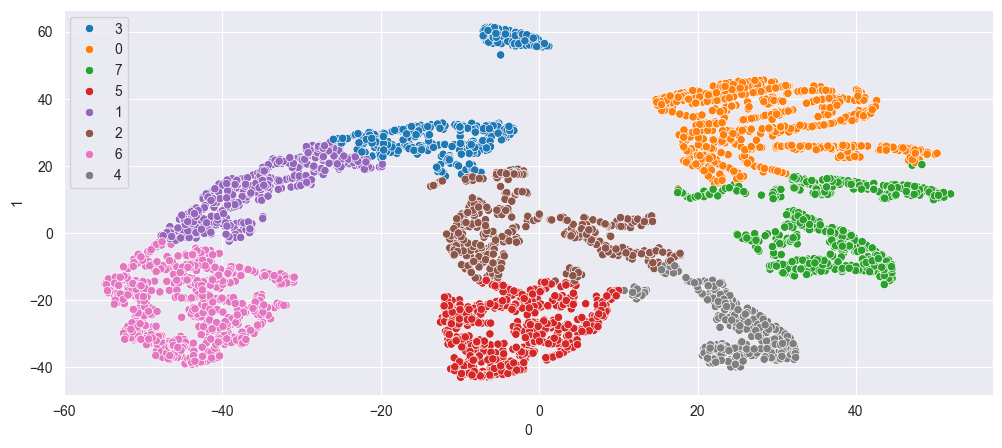

In [53]:
# Visualization

fig = plt.figure(figsize = (12, 5))
sns.scatterplot(data = rfm_tsne, x = 0, y = 1, hue = k_means.labels_.astype('str'));

The results: there are seven customer segments. It is reasonable to create a profile for these segments. To create a cluster profile, it is necessary to group the RFM table by the resulting clusters and calculate the average for each feature.

In [54]:
rfm_tsne.head()

0          1  label
0  -5.096237  32.750000      3
1  19.839493  30.269058      0
2  30.227396  -1.920902      7
3   9.074645 -19.684454      5
4  -8.583499  27.215914      3

In [55]:
rfm.head()

Recency  Frequency  Monetary
CustomerID                              
12346           325          1      0.00
12347             2          7   4310.00
12348            75          4   1437.24
12349            18          1   1457.55
12350           310          1    294.40

In [56]:
rfm['Label'] = rfm_tsne['label'].values
rfm_group = rfm.groupby('Label').mean()

display(rfm_group)

print('Max average value of Recency: {}'.format(round(rfm_group['Recency'].max())))

Recency  Frequency     Monetary
Label                                    
0       27.239826   7.444767  2674.837616
1      181.439506   1.000000   273.465160
2      188.733906   2.484979   695.489120
3      313.044554   1.019802   275.923490
4       33.666667   2.939655   936.196839
5       39.706320   1.979554   604.060818
6       46.329268   1.000000   321.538796
7       44.743970   4.324675  1294.389184

Max average value of Recency: 313


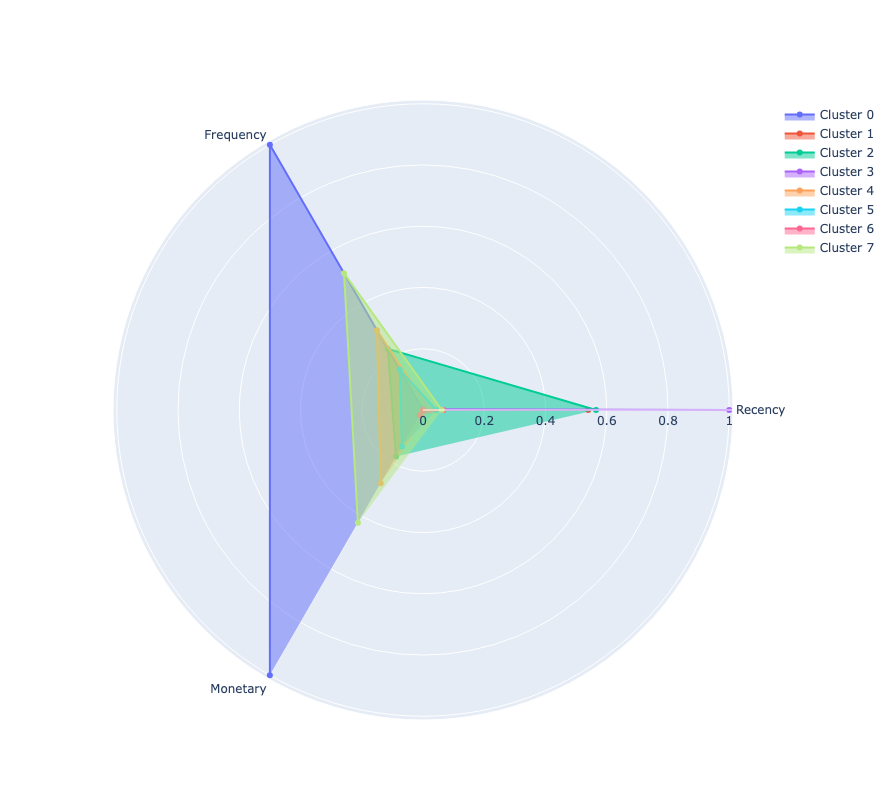

In [57]:
# Visualization of clusters to review the profile

plot_cluster_profile(rfm_group, 8)

It pays off to reduce the clustering problem to a classification problem. The true cluster labels were created and there are customers that are described by RFM characteristics. Therefore below there will be done the search of the best model to predict a customer segment based on RFM characteristics.

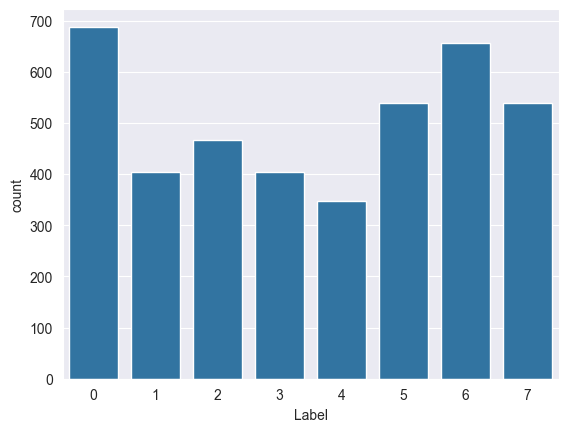

In [58]:
sns.countplot(data = rfm, x = 'Label');

In [59]:
# Matrix of observations X and a vector of correct answers y

X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Label']

# Graph above shows that classes are not balanced, therefore stratify is used

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

print('Number of customers in test sample:', y_test.shape[0])

Number of customers in test sample: 809


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
# Random Forest Classifier Model

param_grid = {'max_depth' : range(5, 15),
             'criterion' : ['gini', 'entropy'],
             'n_estimators' : [100, 200, 500]}

grid_rf = GridSearchCV(estimator = RandomForestClassifier(random_state = 42),
                      param_grid = param_grid,
                      cv = 5,
                      n_jobs = -1)
grid_rf.fit(X_train, y_train)

y_train_pred = grid_rf.predict(X_train)
y_test_pred = grid_rf.predict(X_test)

print('Best parameters: {}'.format(grid_rf.best_params_))
print('Train Accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Best parameters: {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 100}
Train Accuracy: 1.000
Test Accuracy: 0.989


In [62]:
# Gradient Boosting Classifier

param_grid = {'max_depth' : range(3, 7),
             'learning_rate': [0.001, 0.01, 0.1],
             'n_estimators' : [100, 200, 500]}

grid_gb = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 42),
                      param_grid = param_grid,
                      cv = 5,
                      n_jobs = -1,
                      scoring = 'accuracy')
grid_gb.fit(X_train, y_train)

y_train_pred = grid_gb.predict(X_train)
y_test_pred = grid_gb.predict(X_test)

print('Best Parameters: {}'.format(grid_gb.best_params_))
print('Train Accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Train Accuracy: 1.000
Test Accuracy: 0.988
